# Machine Learning for Predictive Maintenance Case 1 - (MyToolBox)

## Multi-labels classification ##

<i>Python notebook created on October 2018. </i>
* Edited by <b>Karim Choukri.</b> (kchoukri012@gmail.com)
* Use case data extracted from <b>Mary Wahl</b> (https://gallery.azure.ai/Notebook/Predictive-Maintenance-Modelling-Guide-Python-Notebook-1)


The business problem for this example is about predicting problems caused by component failures such that the question "What is the probability that a machine will fail in the near future due to a failure of a certain component?" can be answered. The problem is formatted as a multi-class classification problem and a machine learning algorithm is used to create the predictive model that learns from historical data collected from machines. In the following sections, we go through the steps of implementing such a model which are feature engineering, label construction, training and evaluation. 

## Data Cleaning and Exploration##

#### Python libraries ####

In [130]:
# for graphics
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Data manipulation
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle

# tools and metrics.
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, f1_score

# Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier as xgb

# Others
import warnings

In [2]:
# General settings
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

### Useful functions

In [3]:
def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    #print("Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels")
    #print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(["accuracy", "precision", "recall", "F1"])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(["macro precision", "macro recall", "macro F1"])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(["average accuracy",
                          "micro-averaged precision/recall/F1"])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(["majority class accuracy", "majority class recall",
                          "majority class precision", "majority class F1"])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(["expected accuracy", "kappa"])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(["random guess accuracy", "random guess precision",
                          "random guess recall", "random guess F1"])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(["random weighted guess accuracy",
                          "random weighted guess precision",
                          "random weighted guess recall",
                          "random weighted guess F1"])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

In [4]:
def plot_multi_roc_curve(target_test_binarized, target_predicted_proba, labels, fig = 1):

    horizon = target_predicted_proba.shape[0]
    n_classes = len(labels)
    yy_test = target_test_binarized

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i,cl in enumerate(labels):
        fpr[cl], tpr[cl], _ = roc_curve(yy_test[:, i], target_predicted_proba[:,i])
        roc_auc[cl] = auc(fpr[cl], tpr[cl])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(yy_test.ravel(), target_predicted_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[cl] for cl in labels]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for cl in labels:
        mean_tpr += interp(all_fpr, fpr[cl], tpr[cl])

    #Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(fig)
    plt.clf()
    plt.figure(fig, figsize=(10, 7))

    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['cornflowerblue', 'aqua', 'darkorange' ])
    for cl, color in zip(labels, colors):
        lab_text = "ROC curve of class " + str(cl) + " (area = " + str(np.round(roc_auc[cl], decimals = 3)) + ")"
        plt.plot(fpr[cl], tpr[cl], 
                 color=color, 
                 lw=lw,
                 label= lab_text)

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Variables

Common data sources for predictive maintenance problems are :

- Failure history: The failure history of a machine or component within the machine.
- Maintenance history: The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
- Machine conditions and usage: The operating conditions of a machine e.g. data collected from sensors.
- Machine features: The features of a machine, e.g. engine size, make and model, location.
- Operator features: The features of the operator, e.g. gender, past experience

The data for this example comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age. Datasets are grouped as following:

- Fault history: The fault history of a machine or a component inside the machine.
- Maintenance history: The repair history of a machine, for example, error codes, previous maintenance activities or replacement of components.
- Conditions and use of the machines: The operating conditions of a machine, for example, data collected from the sensors.
- Characteristics of the machines: The characteristics of a machine, for example, engine size, make and model, age.

In [5]:
telemetry = pd.read_csv("./data/PdM_telemetry.csv", error_bad_lines=False)
alarms = pd.read_csv("./data/PdM_errors.csv", error_bad_lines=False)
maint = pd.read_csv("./data/PdM_maint.csv", error_bad_lines=False)
failures = pd.read_csv("./data/PdM_failures.csv", error_bad_lines=False)
machines = pd.read_csv("./data/PdM_machines.csv", error_bad_lines=False)

b'Skipping line 92490: expected 6 fields, saw 9\n'


NOTE:
    To select variables use FeatureSelector.
    Data cleaning cases:
        Name of columns
        Incorrect characters
        Null values
        Incorrect data types
        Discover incorrect values
        Duplicate values
        Flatten dataset

### Telemetry ####

Data in telemetry time series with measurements of voltage, rotation, pressure and vibration collected from 100 machines in real time, averaged in each hour and collected during 2015. Measurments are collected every hour.

In [6]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [7]:
telemetry.tail()

,datetime,machineID,volt,rotate,pressure,vibration
968583,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
968584,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
968585,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
968586,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259
968587,2016-01-01 06:00:00,100,171.336037,496.096870,79.095538,37.845245


In [8]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968588 entries, 0 to 968587
Data columns (total 6 columns):
datetime     968588 non-null object
machineID    968588 non-null int64
volt         968588 non-null float64
rotate       968588 non-null float64
pressure     968588 non-null float64
vibration    968588 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 44.3+ MB


In [9]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [10]:
telemetry["machineID"].nunique()

100

In [11]:
# We change the datetime format because it comes as a string.
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [12]:
# the dtype of this series is 'object' because it has mixed types
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

Any missing values ?

In [13]:
for col in telemetry.columns:
    nancnt = telemetry[col].isnull().sum()
    print("%16s %s nan" % (col, str(nancnt)))

        datetime 0 nan
       machineID 0 nan
            volt 0 nan
          rotate 0 nan
        pressure 0 nan
       vibration 0 nan


Let's figure out telemetry recorded variables distribution densities. The goal is to identify if any particular pattern within collected variables and how they behave around their mean value. Another sought objective, is to verify if there are any possible outliers in the measurments. 

<Figure size 720x576 with 0 Axes>

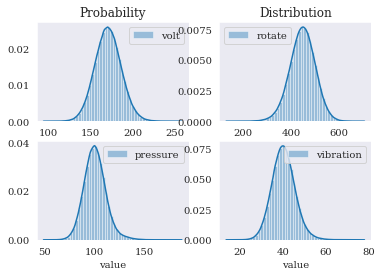

In [14]:
# Kernel Density function -> PDF (Probablity Distribution function)

"""
A normal distribution tells us about a representative sample (Central Limit Theorem).
It speaks to us of a natural behavior.
It shows a single group to work with (otherwise clustering).
Parametric models expect normal distributions because they use the mean, the std, etc.
The non-parametric models e.g. CART (Classification and Regression Trees),
are insensitive to the distribution of data,
the only thing that matters is to create nodes that maximize the separation of classes.
In other cases, apply logarithmic transformations, quantile regression, normalization to the data.
Parametric: Linear Regression
Non-parametric: Decision Tree
Are there changes or not as the dataset grows?
"""

plt.figure(figsize=(10, 8))
fig, ax = plt.subplots(2,2)
font = {'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)

for i,col in enumerate(list(telemetry.columns)[2:]):
    
    ax = plt.subplot(2,2,i+1)
    sns.distplot(telemetry[col],
                 norm_hist=True,
                 kde=True,
                 ax=ax,
                 label=col)
    plt.legend()
    plt.grid()
    if i in [2,3]:
        ax.set_xlabel('value')
    if i == 0: ax.set_title('Probability')
    if i == 1: ax.set_title('Distribution')

#telemetry["pressure"].plot(kind="kde")
#plt.title("Pressure distribution")
#plt.ylabel("Density")
#plt.xlabel("Pressure")
plt.show()

In [15]:
# We confirm integrity; total, average, standard deviation, minimum, maximum, and quantiles.
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,170.774119,446.591205,100.841515,40.383648
std,30.450409,15.507488,52.701718,11.028763,5.366198
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,18.000000,160.298184,412.278255,93.492369,36.778303
50%,45.000000,170.597611,447.555368,100.414332,40.237433
75%,73.000000,181.006196,482.154486,107.535244,43.781329
max,100.000000,255.124717,695.020984,185.951998,76.791072


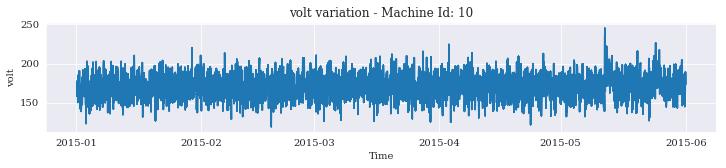

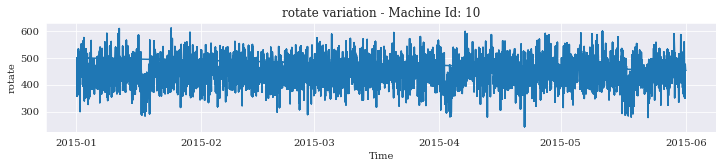

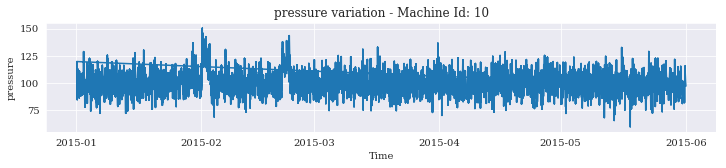

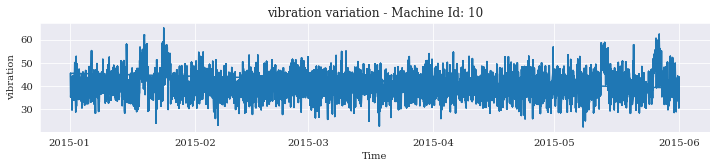

In [16]:
# We show an example graph of the voltage values for machine Id 1 during the first 6 months of 2015.

machine_id = 10

for i,col in enumerate(list(telemetry.columns)[2:]):
    plot_df = pd.DataFrame()
    temp = telemetry.loc[
        (telemetry["machineID"] == machine_id)
        & (telemetry["datetime"] > pd.to_datetime("2015-01-01"))
        & (telemetry["datetime"] < pd.to_datetime("2015-06-01")), ["datetime", col] ]
    plot_df = temp.set_index(temp.datetime).drop("datetime", axis=1)

    plt.figure(figsize=(12, 2))
    plt.plot(plot_df[col])
    plt.title("{} variation - Machine Id: {}".format(col,machine_id) )
    plt.ylabel(col)

    # We make the x-labels readable.
    adf = plt.gca().get_xaxis().get_major_formatter()
    adf.scaled[1.0] = "%m-%d"
    plt.xlabel("Time")
    plt.show()

### Alarms ####

These are <b> warning </b> alarms generated when the machine is still operating and are not considered failures.
The date and alarm times are rounded up to the nearest hour since the telemetry data is collected per hour.

In [17]:
alarms.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [18]:
alarms.tail()

,datetime,machineID,errorID
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3
3918,2015-12-22 03:00:00,100,error3


In [19]:
alarms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
datetime     3919 non-null object
machineID    3919 non-null int64
errorID      3919 non-null object
dtypes: int64(1), object(2)
memory usage: 91.9+ KB


Any missing values?

In [20]:
for col in alarms.columns:
    nancnt = alarms[col].isnull().sum()
    print("%16s %s nan" % (col, str(nancnt)))

        datetime 0 nan
       machineID 0 nan
         errorID 0 nan


In [21]:
# Format the date and time field that comes as string.
# The categories allow the comparison between values, automatic ordering, simpler graphing and other functions.
# Also less memory (similar to "factor" in R).
alarms["datetime"] = pd.to_datetime(alarms["datetime"], format="%Y-%m-%d %H:%M:%S")
alarms["errorID"] = alarms["errorID"].astype("category")

alarms.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [22]:
alarms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
datetime     3919 non-null datetime64[ns]
machineID    3919 non-null int64
errorID      3919 non-null category
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 65.3 KB


In [23]:
[alarms.datetime.min(), alarms.datetime.max()]

[Timestamp('2015-01-01 06:00:00'), Timestamp('2016-01-01 05:00:00')]

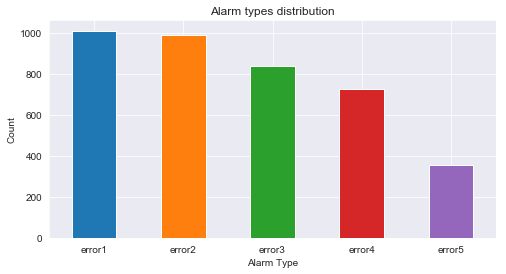

In [24]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
alarms["errorID"].value_counts().plot(kind="bar", rot=0)
plt.title("Alarm types distribution")
plt.ylabel("Count")
plt.xlabel("Alarm Type")
plt.show()

                     error1  error2  error3  error4  error5
2015-01-01 20:00:00       1       0       0       0       0
2015-01-06 04:00:00       0       0       1       0       0
2015-01-18 06:00:00       0       1       0       0       0
2015-01-18 06:00:00       0       0       1       0       0
2015-01-22 05:00:00       1       0       0       0       0


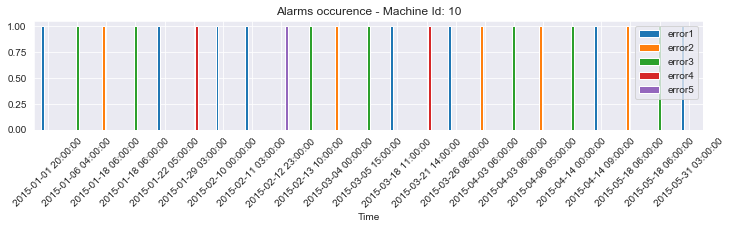

In [25]:
machine_id = 10
col = []
temp = alarms.loc[
        (alarms["machineID"] == machine_id)
        & (alarms["datetime"] > pd.to_datetime("2015-01-01"))
        & (alarms["datetime"] < pd.to_datetime("2015-06-01")), ["datetime", "errorID"] ]
plot_df = pd.concat([temp,pd.get_dummies(temp.errorID )], axis=1).set_index(temp.datetime.values).drop(["datetime", "errorID"], axis=1)

col = list(plot_df.columns)
print(plot_df.head())

plot_df.plot(kind="bar", figsize=(12, 2), rot=45)
plt.title("Alarms occurence - Machine Id: {}".format(machine_id) )
plt.xlabel("Time")

#for c in col:
#    plt.figure(figsize=(12, 1))
#    plot_df[c].plot(kind="bar")
    #plt.step(plot_df["datetime"], plot_df[c])
#    plt.title("{} occurence - Machine Id: {}".format(c ,machine_id) )
#    plt.ylabel(c )

    # We make the x-labels readable.
#    adf = plt.gca().get_xaxis().get_major_formatter()
    #adf.scaled[1.0] = "%m-%d"
#    plt.xlabel("Time")
    
plt.show()

### Maintenance ####

Records that correspond <b> to both regular inspections and failures </b>.
A record is generated if a component is replaced during the scheduled inspection or replaced due to a failure.
The records that are created due to failures will be called as such, failures.
The maintenance data has both 2014 and 2015 records.

In [26]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [27]:
maint.tail()

,datetime,machineID,comp
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2
3285,2015-12-24 06:00:00,100,comp2


In [28]:
maint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
datetime     3286 non-null object
machineID    3286 non-null int64
comp         3286 non-null object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB


Any missing values?

In [29]:
for col in maint.columns:
    nancnt = maint[col].isnull().sum()
    print("%16s %s nan" % (col, str(nancnt)))

        datetime 0 nan
       machineID 0 nan
            comp 0 nan


In [30]:
# Format the date and time field that comes as string.
maint["datetime"] = pd.to_datetime(maint["datetime"], format="%Y-%m-%d %H:%M:%S")
maint["comp"] = maint["comp"].astype("category")
maint.dtypes

datetime     datetime64[ns]
machineID             int64
comp               category
dtype: object

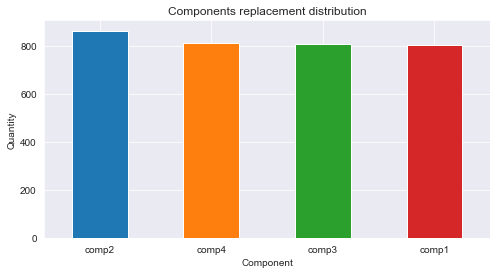

In [31]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
maint["comp"].value_counts().plot(kind="bar", rot=0)
plt.title("Components replacement distribution")
plt.ylabel("Quantity")
plt.xlabel("Component")
plt.show()

                     comp1  comp2  comp3  comp4
2015-01-04 06:00:00      0      0      0      1
2015-01-19 06:00:00      0      0      1      0
2015-01-19 06:00:00      0      1      0      0
2015-02-03 06:00:00      0      1      0      0
2015-02-18 06:00:00      0      1      0      0


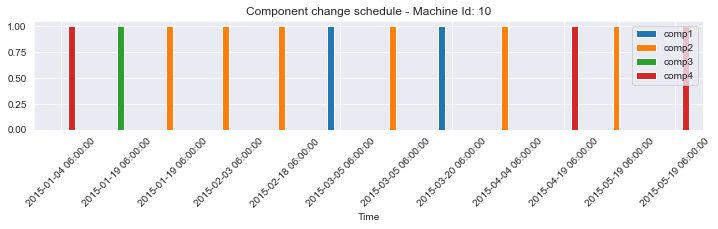

In [32]:
machine_id = 10
col = []
temp = maint.loc[
        (maint["machineID"] == machine_id)
        & (maint["datetime"] > pd.to_datetime("2015-01-01"))
        & (maint["datetime"] < pd.to_datetime("2015-06-01")), ["datetime", "comp"] ]
plot_df = pd.concat([temp,pd.get_dummies(temp.comp )], axis=1).set_index(temp.datetime.values).drop(["datetime", "comp"], axis=1)

col = list(plot_df.columns)
print(plot_df.head())

plot_df.plot(kind="bar", figsize=(12, 2), rot=45)
plt.title("Component change schedule - Machine Id: {}".format(machine_id) )
plt.xlabel("Time")

#for c in col:
#    plt.figure(figsize=(12, 1))
#    plot_df[c].plot(kind="bar")
    #plt.step(plot_df["datetime"], plot_df[c])
#    plt.title("Component {} change - Machine Id: {}".format(c ,machine_id) )
#    plt.ylabel(c )

    # We make the x-labels readable.
#    adf = plt.gca().get_xaxis().get_major_formatter()
    #adf.scaled[1.0] = "%m-%d"
#    plt.xlabel("Time")
    
plt.show()

### Machines ####

This dataset includes information about the machines: type of model and age (years in service).

In [33]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [34]:
machines.tail()

,machineID,model,age
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14
99,100,model4,5


In [35]:
machines.shape

(100, 3)

In [36]:
machines.dtypes

machineID     int64
model        object
age           int64
dtype: object

Any missing values?

In [37]:
for col in machines.columns:
    nancnt = machines[col].isnull().sum()
    print("%16s %s nan" % (col, str(nancnt)))

       machineID 0 nan
           model 0 nan
             age 0 nan


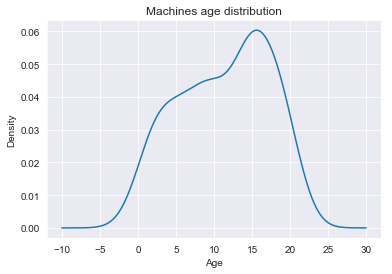

In [38]:
# We check if there are several hills because it can suggest two different groups.
machines["age"].plot(kind="kde")
plt.title("Machines age distribution")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

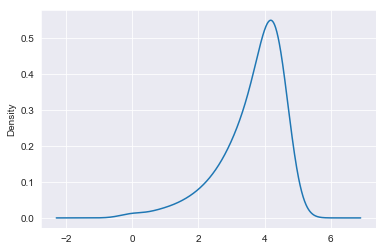

In [39]:
# We apply natural logarithm to normalize.
np.log(machines[machines["age"] != 0].iloc[:, 0]).plot(kind="kde")
plt.show()

In [40]:
machines["model"] = machines["model"].astype("category")
machines.dtypes

machineID       int64
model        category
age             int64
dtype: object

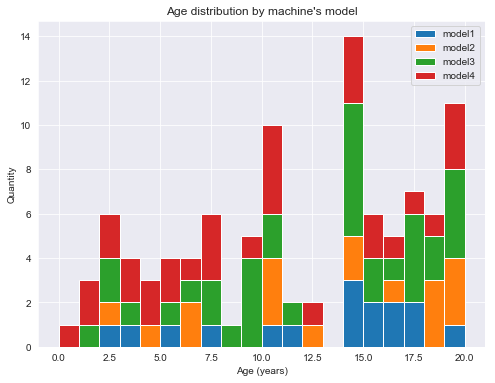

In [41]:
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([
    machines.loc[machines["model"] == "model1", "age"],
    machines.loc[machines["model"] == "model2", "age"],
    machines.loc[machines["model"] == "model3", "age"],
    machines.loc[machines["model"] == "model4", "age"]],
    20, stacked=True, label=["model1", "model2", "model3", "model4"
])
plt.title("Age distribution by machine's model")
plt.xlabel("Age (years)")
plt.ylabel("Quantity")
plt.legend()
plt.show()

### Component failures ####

These are the component replacement records due to <b> failures </b>. Each record has a date and time, machine ID and the failed component. This dataset will be used later to label our classifier targets.

In [42]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [43]:
failures.tail()

,datetime,machineID,failure
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1
760,2015-12-09 06:00:00,100,comp2


In [44]:
failures[failures["machineID"] == machine_id ].head()

,datetime,machineID,failure
53,2015-01-19 06:00:00,10,comp2
54,2015-04-04 06:00:00,10,comp2
55,2015-05-19 06:00:00,10,comp2
56,2015-06-03 06:00:00,10,comp1
57,2015-06-18 06:00:00,10,comp2


In [45]:
failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
datetime     761 non-null object
machineID    761 non-null int64
failure      761 non-null object
dtypes: int64(1), object(2)
memory usage: 17.9+ KB


Any missing values?

In [46]:
for col in failures.columns:
    nancnt = failures[col].isnull().sum()
    print("%16s %s nan" % (col, str(nancnt)))

        datetime 0 nan
       machineID 0 nan
         failure 0 nan


In [47]:
# We format the datetime that comes as string
failures["datetime"] = pd.to_datetime(failures["datetime"], format="%Y-%m-%d %H:%M:%S")
failures["failure"] = failures["failure"].astype("category")
failures.dtypes

datetime     datetime64[ns]
machineID             int64
failure            category
dtype: object

In [48]:
failures.describe(include="all")

,datetime,machineID,failure
count,761,761.000000,761
unique,302,NaN,4
top,2015-01-02 03:00:00,NaN,comp2
freq,18,NaN,259
first,2015-01-02 03:00:00,NaN,NaN
last,2015-12-31 06:00:00,NaN,NaN
mean,NaN,51.911958,NaN
std,NaN,29.515542,NaN
min,NaN,1.000000,NaN
25%,NaN,24.000000,NaN


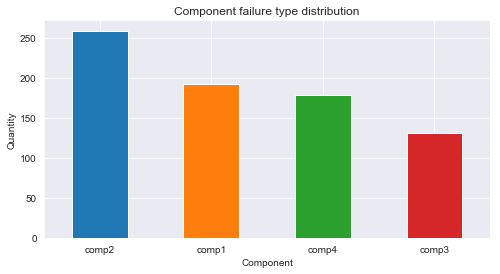

In [49]:
plt.figure(figsize=(8, 4))
failures["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Component failure type distribution")
plt.ylabel("Quantity")
plt.xlabel("Component")
plt.show()

                     comp1  comp2  comp3  comp4
2015-01-19 06:00:00      0      1      0      0
2015-04-04 06:00:00      0      1      0      0
2015-05-19 06:00:00      0      1      0      0


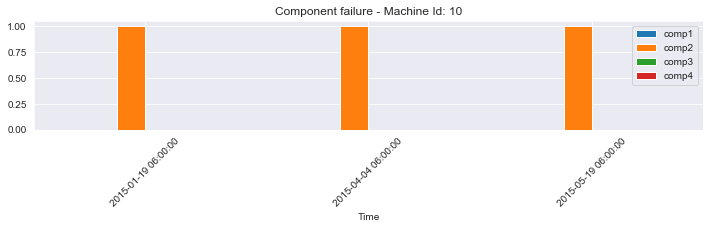

In [50]:
machine_id = 10
col = []
temp = failures.loc[
        (failures["machineID"] == machine_id)
        & (failures["datetime"] > pd.to_datetime("2015-01-01"))
        & (failures["datetime"] < pd.to_datetime("2015-06-01")), ["datetime", "failure"] ]
plot_df = pd.concat([temp,pd.get_dummies(temp.failure )], axis=1).set_index(temp.datetime.values).drop(["datetime", "failure"], axis=1)

col = list(plot_df.columns)
print(plot_df.head())

plot_df.plot(kind="bar", figsize=(12, 2), rot=45)
plt.title("Component failure - Machine Id: {}".format(machine_id) )
plt.xlabel("Time")

#for c in col:
#    plt.figure(figsize=(12, 1))
#    plot_df[c].plot(kind="bar")
    #plt.step(plot_df["datetime"], plot_df[c])
#    plt.title("Component {} failure - Machine Id: {}".format(c ,machine_id) )
#    plt.ylabel(c )

    # We make the x-labels readable.
#    adf = plt.gca().get_xaxis().get_major_formatter()
    #adf.scaled[1.0] = "%m-%d"
#    plt.xlabel("Time")
    
plt.show()

## Feature Engineering ##

Telemetry data almost always come with time stamps, which makes them suitable for calculating delayed features (statistics of certain values within a time window).

We will choose the size of a time window and calculate the aggregate measures (mean, standard deviation, minimum, maximum, etc.) to represent the short-term history.

Next, we will derive the moving average and moving standard deviation of the telemetry data in the last window of 3 hours delay.

In [51]:
# We calculate average values for telemetry characteristics

temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

# we pivot because we need the datetime as an index for "resample" to work (3 hours)
# resample creates the lagging
# closed = 'right' => (6:00, 9:00] or 6:00 <x <= 9:00
# closed = 'left' => [6:00, 9:00) or 6:00 <= x <9:00
# can not be both !
# unstack: returns df to the original format
# we have 100 machines + 4 sensors = 400 columns
# unstack shows a dataseries on the columns as index and returns series (if there are several indexes,then they are rearranged).
# Each 'temp' dataframe has the values of the field that corresponds to it at that moment.

temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").mean().unstack()
    for col in fields
]


In [52]:
temp[0].head() # volts

machineID  datetime           
1          2015-01-01 09:00:00    170.028993
           2015-01-01 12:00:00    164.192565
           2015-01-01 15:00:00    168.134445
           2015-01-01 18:00:00    165.514453
           2015-01-01 21:00:00    168.809347
dtype: float64

In [53]:
temp[3].head() # vibrations

machineID  datetime           
1          2015-01-01 09:00:00    40.893502
           2015-01-01 12:00:00    34.255891
           2015-01-01 15:00:00    41.239405
           2015-01-01 18:00:00    40.373739
           2015-01-01 21:00:00    41.738542
dtype: float64

In [54]:
telemetry_mean_3h = pd.concat(temp, axis=1) # We join the series
telemetry_mean_3h.columns = [col + "_mean_3h" for col in fields] # We assign columns' name.
telemetry_mean_3h.reset_index(inplace=True) # reset the index.
telemetry_mean_3h.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


In [55]:
# We repeat for the standard deviation.
temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").std().unstack()
    for col in fields
]


In [56]:
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00     6.721032
           2015-01-01 12:00:00     7.596570
           2015-01-01 15:00:00    10.124584
           2015-01-01 18:00:00     4.673269
           2015-01-01 21:00:00    14.752132
dtype: float64

In [57]:
telemetry_std_3h = pd.concat(temp, axis=1)
telemetry_std_3h.columns = [i + "_std_3h" for i in fields]
telemetry_std_3h.reset_index(inplace=True)
telemetry_std_3h.head()

,machineID,datetime,volt_std_3h,rotate_std_3h,pressure_std_3h,vibration_std_3h
0,1,2015-01-01 09:00:00,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,10.124584,55.084734,5.909721,5.169304
3,1,2015-01-01 18:00:00,4.673269,42.047278,4.554047,2.106108
4,1,2015-01-01 21:00:00,14.752132,47.048609,4.244158,2.207884


In [58]:
# To capture a longer-term effect, the 24-hour lagging functions are also calculated.
# We create new values with moving averages of 24 hours, and then we select the first result every 3 hours.
# In this way we can combine the results with the characteristics of previous lagging (calculated at 3 hours).

temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).mean().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00   NaN
           2015-01-01 12:00:00   NaN
           2015-01-01 15:00:00   NaN
           2015-01-01 18:00:00   NaN
           2015-01-01 21:00:00   NaN
dtype: float64

In [59]:
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + "_mean_24h" for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
# Due to the moving average method, the first 23 records are null; We have to eliminate them.
# It does not happen at the end of the frame because rolling comes at the end.
# We finish with a frame of less data than the original telemetry as well as the previous one of 3H.
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h["volt_mean_24h"].isnull()]

In [60]:
telemetry_mean_24h.head()

,machineID,datetime,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214


In [61]:
# We repeat for the standard deviation.
temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).std().resample("3H", closed="left", label="right").first().unstack(level=-1)
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00   NaN
           2015-01-01 12:00:00   NaN
           2015-01-01 15:00:00   NaN
           2015-01-01 18:00:00   NaN
           2015-01-01 21:00:00   NaN
dtype: float64

In [62]:
telemetry_std_24h = pd.concat(temp, axis=1)
telemetry_std_24h.columns = [i + "_std_24h" for i in fields]
telemetry_std_24h.reset_index(inplace=True)
telemetry_std_24h = telemetry_std_24h.loc[-telemetry_std_24h["volt_std_24h"].isnull()]

In [63]:
telemetry_std_24h.head(10)

,machineID,datetime,volt_std_24h,rotate_std_24h,pressure_std_24h,vibration_std_24h
7,1,2015-01-02 06:00:00,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,13.954518,43.490234,8.061653,5.898069
12,1,2015-01-02 21:00:00,14.402740,42.626186,10.408012,5.941890
13,1,2015-01-03 00:00:00,15.513819,40.395881,10.833294,5.737671
14,1,2015-01-03 03:00:00,15.726970,39.648116,11.904700,5.601191
15,1,2015-01-03 06:00:00,15.635083,41.828592,11.326412,5.583521
16,1,2015-01-03 09:00:00,13.995465,40.843882,11.036546,5.561553


In [64]:
# We combine the features created so far.
# We take the values 2: 6 to avoid ID and duplicate dates.
# axis = 0 we move in the direction of the rows, axis = 1, we move in the direction of the columns.
telemetry_feat = pd.concat([
    telemetry_mean_3h,
    telemetry_std_3h.iloc[:, 2:6],
    telemetry_mean_24h.iloc[:, 2:6],
    telemetry_std_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_std_3h,rotate_std_3h,pressure_std_3h,vibration_std_3h,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_std_24h,rotate_std_24h,pressure_std_24h,vibration_std_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069


In [65]:
telemetry_feat.describe()

,machineID,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_std_3h,rotate_std_3h,pressure_std_3h,vibration_std_3h,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_std_24h,rotate_std_24h,pressure_std_24h,vibration_std_24h
count,291300.00000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,170.771416,446.612973,100.855301,40.384328,13.299858,44.456335,8.885822,4.440660,170.772579,446.613440,100.854547,40.384564,14.918849,49.947916,10.046687,5.002065
std,28.86612,9.497201,33.122865,7.408854,3.476641,6.966647,23.216421,4.656341,2.320066,4.716970,18.074248,4.733098,2.059861,2.260726,7.682126,1.713726,0.799820
min,1.00000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.75000,164.445576,427.568132,96.238173,38.147839,8.027455,26.903567,5.370647,2.684308,168.070890,441.549802,98.668589,39.354062,13.358663,44.668824,8.924317,4.460347
50%,50.50000,170.430790,448.385564,100.233139,40.146085,12.495595,41.795700,8.345785,4.173854,170.210913,449.212554,100.097694,40.072752,14.853948,49.613807,9.921407,4.958594
75%,75.25000,176.607051,468.447680,104.404520,42.227392,17.689118,59.103715,11.789645,5.898997,172.459612,456.368008,101.611121,40.833364,16.394764,54.821318,10.980498,5.484480
max,100.00000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783


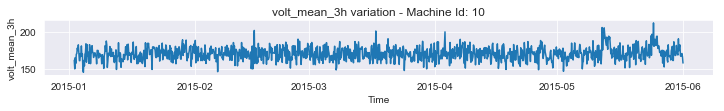

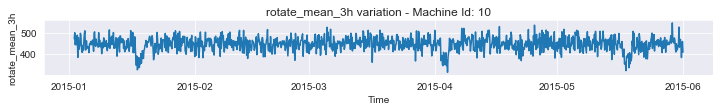

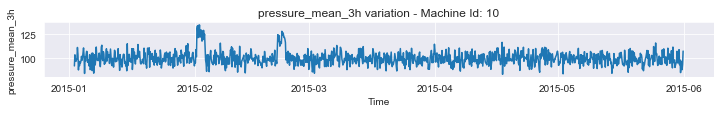

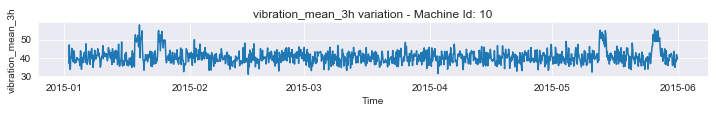

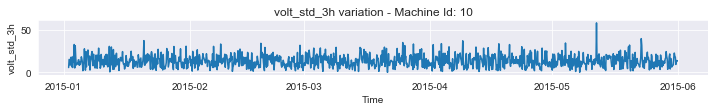

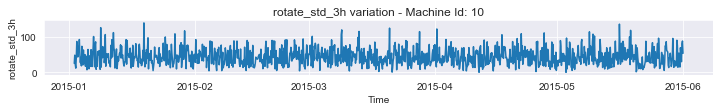

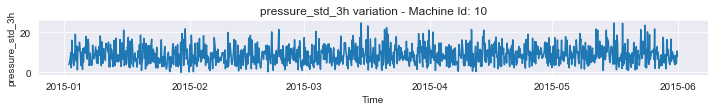

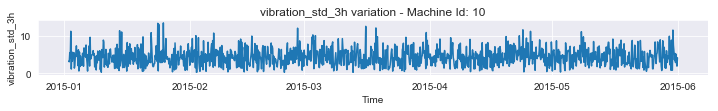

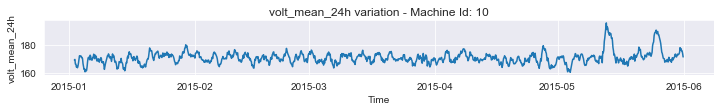

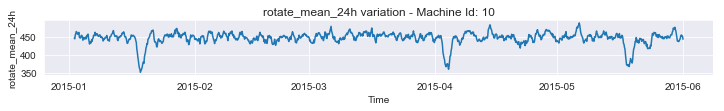

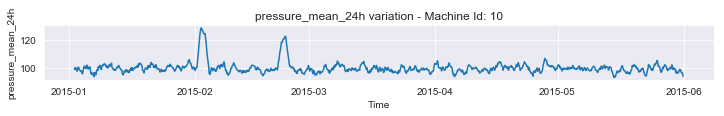

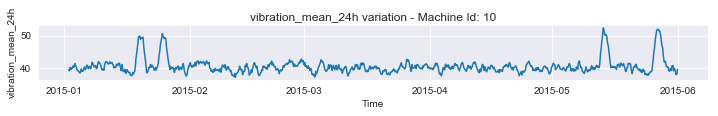

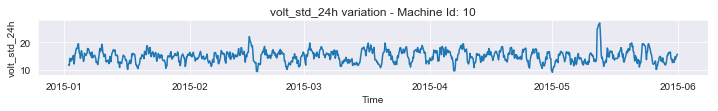

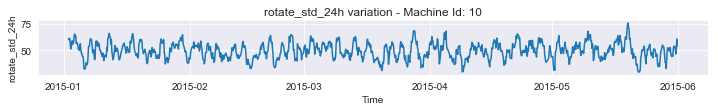

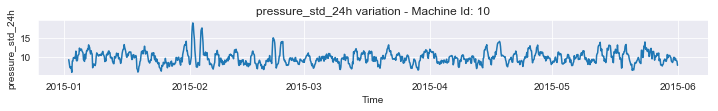

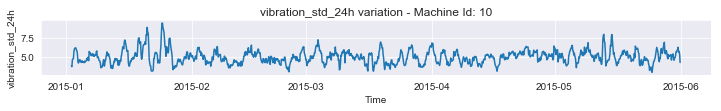

In [66]:
# We show an example graph of the voltage values for machine Id 1 during the first 6 months of 2015.

machine_id = 10

for i,col in enumerate(list(telemetry_feat.columns)[2:]):
    plot_df = telemetry_feat.loc[
        (telemetry_feat["machineID"] == machine_id)
        & (telemetry_feat["datetime"] > pd.to_datetime("2015-01-01"))
        & (telemetry_feat["datetime"] < pd.to_datetime("2015-06-01")), ["datetime", col] ]

    plt.figure(figsize=(12, 1))
    plt.plot(plot_df["datetime"], plot_df[col])
    plt.title("{} variation - Machine Id: {}".format(col,machine_id) )
    plt.ylabel(col)

    # We make the x-labels readable.
    adf = plt.gca().get_xaxis().get_major_formatter()
    adf.scaled[1.0] = "%m-%d"
    plt.xlabel("Time")
    plt.show()

### Lag Characteristics in Alarms ####

Like telemetry data, alarms come with timestamps. We count the number of alarms of each type in a delayed window.

We start by reformatting the alarms data in order to have one entry per machine per time, when at least 
one alarm occurred.
We create a column for each type of alarms.

In [67]:
"""
We start by reformatting the alarms data in order to have one entry per machine per time, when at least 
one alarm occurred.
We create a column for each type of alarms.
"""
alarm_count = pd.get_dummies(alarms) # One-Hot error encoding
alarm_count.columns = ["datetime", "machineID", "alarm1", "alarm2", "alarm3", "alarm4", "alarm5"]
alarm_count.head(15)

,datetime,machineID,alarm1,alarm2,alarm3,alarm4,alarm5
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,0,1,0,0
2,2015-01-04 06:00:00,1,0,0,0,0,1
3,2015-01-10 15:00:00,1,0,0,0,1,0
4,2015-01-22 10:00:00,1,0,0,0,1,0
5,2015-01-25 15:00:00,1,0,0,0,1,0
6,2015-01-27 04:00:00,1,1,0,0,0,0
7,2015-03-03 22:00:00,1,0,1,0,0,0
8,2015-03-05 06:00:00,1,1,0,0,0,0
9,2015-03-20 18:00:00,1,1,0,0,0,0


The dataframe dates are repeated, so we group by date.
We combine alarms for a given machine at a specific time.
We do sum in case there are multiple alarms of the same type at the same time, but not expected.

In [68]:
"""
The dataframe dates are repeated, so we group by date.
We combine alarms for a given machine at a specific time.
We do sum in case there are multiple alarms of the same type at the same time, but not expected.
"""
alarm_count_grouped = alarm_count.groupby(["machineID", "datetime"]).sum().reset_index()
alarm_count_grouped.head(10)

,machineID,datetime,alarm1,alarm2,alarm3,alarm4,alarm5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
5,1,2015-01-25 15:00:00,0,0,0,1,0
6,1,2015-01-27 04:00:00,1,0,0,0,0
7,1,2015-03-03 22:00:00,0,1,0,0,0
8,1,2015-03-05 06:00:00,1,0,0,0,0
9,1,2015-03-20 18:00:00,1,0,0,0,0


We merge recorded errors with the telemetry reference dataframe and make sure to assign the value 0
to the non-coincidences. That is why we only look for a match with datetime and machineID.

In [69]:
"""
We merge recorded errors with the telemetry reference dataframe and make sure to assign the value 0
to the non-coincidences. That is why we only look for a match with datetime and machineID.
"""
alarm_count_filtered = telemetry[["datetime", "machineID"]].merge(
    alarm_count_grouped,
    on=["machineID", "datetime"],
    how="left"
).fillna(0.0)

alarm_count_filtered.head()

,datetime,machineID,alarm1,alarm2,alarm3,alarm4,alarm5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0


In [70]:
# We check that there are no anomalies.
alarm_count_filtered.describe()

,machineID,alarm1,alarm2,alarm3,alarm4,alarm5
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,0.001147,0.001128,0.000958,0.000813,0.000392
std,30.450409,0.033848,0.033573,0.030938,0.028493,0.019803
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We calculate the total number of alarms for each type of alarm during 24-hour periods.

We will take points every 3 hours.

In [71]:
# We calculate the total number of alarms for each type of alarm during 24-hour periods.
# We will take points every 3 hours.

temp = []
fields = ["alarm%d" % i for i in range(1,6) ]

temp = [
    pd.pivot_table(
        alarm_count_filtered,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).sum().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]
temp[0].head(10)

machineID  datetime           
1          2015-01-01 09:00:00    NaN
           2015-01-01 12:00:00    NaN
           2015-01-01 15:00:00    NaN
           2015-01-01 18:00:00    NaN
           2015-01-01 21:00:00    NaN
           2015-01-02 00:00:00    NaN
           2015-01-02 03:00:00    NaN
           2015-01-02 06:00:00    0.0
           2015-01-02 09:00:00    0.0
           2015-01-02 12:00:00    0.0
dtype: float64

In [72]:
alarm_count_total = pd.concat(temp, axis=1)
alarm_count_total.columns = [i + "_count" for i in fields]
alarm_count_total.reset_index(inplace=True)
alarm_count_total = alarm_count_total.dropna()
alarm_count_total.head()

,machineID,datetime,alarm1_count,alarm2_count,alarm3_count,alarm4_count,alarm5_count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


In [73]:
alarm_count_total["alarm5_count"].unique()

array([0., 1., 2.])

In [74]:
alarm_count_total.describe()

,machineID,alarm1_count,alarm2_count,alarm3_count,alarm4_count,alarm5_count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


### Time since the Last Replacement for Maintenance ####

Maintenance records contain the information of the component replacement records.
A possible feature or predictive variable to add to our dataset, could be to calculate how much time has passed since a component was replaced for the last time, since how long a component is being used, and therefore derive the greater the degradation.

In this section, knowledge of the domain plays an important role in understanding the predictive factors of a problem.
Therefore, the days since the last component replacement are calculated for each type of component as a feature from the maintenance data.

In [75]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [76]:
# OneHot encoding for component categories
comp_rep = pd.get_dummies(maint)
comp_rep.columns = ["datetime", "machineID", "comp1", "comp2", "comp3", "comp4"]
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2014-06-01 06:00:00,1,0,1,0,0
1,2014-07-16 06:00:00,1,0,0,0,1
2,2014-07-31 06:00:00,1,0,0,1,0
3,2014-12-13 06:00:00,1,1,0,0,0
4,2015-01-05 06:00:00,1,0,0,0,1


We combine repairs for a certain machine at a certain time.
If we do not group by date we can see another perspective.
We find which components fail together, as we group by date.

In [77]:
# We combine repairs for a certain machine at a certain time.
# If we do not group by date we can see another perspective.
# We find which components fail together, as we group by date.
comp_rep = comp_rep.groupby(["machineID", "datetime"]).sum().reset_index()
comp_rep.head()

,machineID,datetime,comp1,comp2,comp3,comp4
0,1,2014-06-01 06:00:00,0,1,0,0
1,1,2014-07-16 06:00:00,0,0,0,1
2,1,2014-07-31 06:00:00,0,0,1,0
3,1,2014-12-13 06:00:00,1,0,0,0
4,1,2015-01-05 06:00:00,1,0,0,1


In [78]:
comp_rep.shape

(2528, 6)

We merge recorded component replacements with the telemetry reference dataframe.

We make sure to add the timestamps where there were no replacements.

In [79]:
# We merge recorded component replacements with the telemetry reference dataframe.
# We make sure to add the timestamps where there were no replacements.
comp_rep = telemetry[["datetime", "machineID"]].merge(comp_rep, 
                                                      on=["datetime", "machineID"],
                                                      how="outer").fillna(0).sort_values(by=["machineID", "datetime"]
)
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
968588,2014-06-01 06:00:00,1,0.0,1.0,0.0,0.0
968589,2014-07-16 06:00:00,1,0.0,0.0,0.0,1.0
968590,2014-07-31 06:00:00,1,0.0,0.0,1.0,0.0
968591,2014-12-13 06:00:00,1,1.0,0.0,0.0,0.0
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0


In [80]:
comp_rep.shape

(968953, 6)

In [81]:
components = ["comp1", "comp2", "comp3", "comp4"]
for comp in components:
    # We want to obtain the date of the change of the most recent component.
    comp_rep.loc[comp_rep[comp] < 1, comp] = None # We fill the samples with null without replacement.
    # the dates of the tickets that do have replacements.
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
    # We make a forward-fill of the most recent dates of a component change.
    # We fill in with the last valid value found top-bottom.
    comp_rep[comp] = pd.to_datetime(comp_rep[comp].fillna(method="ffill"))

# We eliminated samples from 2014, as they could be null, since the maneuvers began that year.
comp_rep = comp_rep.loc[comp_rep["datetime"] > pd.to_datetime("2015-01-01")]
comp_rep.head(10)

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
1,2015-01-01 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
2,2015-01-01 07:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
3,2015-01-01 07:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
4,2015-01-01 08:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
5,2015-01-01 08:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
6,2015-01-01 09:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
7,2015-01-01 09:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
8,2015-01-01 10:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
9,2015-01-01 10:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00


We replace the most recent change dates by the number of days since the most recent change.

In [82]:
# We replace the most recent change dates by the number of days since the most recent change.
for comp in components: 
    comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D")
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
2,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
3,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
4,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333


In [83]:
comp_rep.describe()

,machineID,comp1,comp2,comp3,comp4
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,54.634332,51.758970,53.299393,52.278293
std,30.450409,63.826724,60.670415,59.018920,57.948910
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,13.333333,11.875000,13.208333,12.833333
50%,45.000000,33.291667,29.333333,32.625000,31.875000
75%,73.000000,70.125000,66.041667,68.375000,68.375000
max,100.000000,491.958333,348.958333,370.958333,394.958333


### Machines Characteristics  ####

Machines characteristics can be used without further modifications. These include descriptive information about the type of each machine and its age (number of years in service).

Finally we merge all the developed features.

In [84]:
# Finally we merge all the developed features.
final_feat = telemetry_feat.merge(alarm_count_total, on=["datetime", "machineID"], how="left")
final_feat = final_feat.merge(comp_rep, on=["datetime", "machineID"], how="left")
final_feat = final_feat.merge(machines, on=["machineID"], how="left")
final_feat.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_std_3h,rotate_std_3h,pressure_std_3h,vibration_std_3h,...,alarm2_count,alarm3_count,alarm4_count,alarm5_count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
2,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
3,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
4,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18


In [85]:
final_feat.describe()

,machineID,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_std_3h,rotate_std_3h,pressure_std_3h,vibration_std_3h,volt_mean_24h,...,alarm1_count,alarm2_count,alarm3_count,alarm4_count,alarm5_count,comp1,comp2,comp3,comp4,age
count,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,...,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000,322048.000000
mean,46.231192,170.768411,446.597577,100.838149,40.383141,13.302106,44.455735,8.881637,4.440767,170.769676,...,0.027521,0.027098,0.022925,0.019497,0.009421,54.457997,51.526382,53.080321,52.069375,11.201010
std,30.450378,9.491411,33.167382,7.383769,3.470424,6.969309,23.216651,4.652646,2.320059,4.709159,...,0.165689,0.164310,0.151480,0.139316,0.097084,63.755660,60.536692,58.907684,57.844919,5.805725
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,164.445707,427.538361,96.232695,38.149663,8.028952,26.901973,5.369147,2.684075,168.070800,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,11.875000,13.125000,12.750000,7.000000
50%,45.000000,170.424831,448.393472,100.223955,40.145593,12.491269,41.802809,8.343671,4.173235,170.209023,...,0.000000,0.000000,0.000000,0.000000,0.000000,33.125000,29.250000,32.500000,31.750000,11.000000
75%,73.000000,176.606136,468.433119,104.391447,42.229040,17.690162,59.097634,11.785599,5.901163,172.455485,...,0.000000,0.000000,0.000000,0.000000,0.000000,69.875000,65.656250,68.000000,68.000000,16.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,...,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000


### Labels construction (Objective / Dependent Variable) ####

When using multi-class classification for predicting failure due to a problem, labeling is done by taking a time window prior to the failure of an asset and labeling the feature records that fall into that window as “about to fail due to a problem” while labeling all other records as “normal”. This time window should be picked according to the business case where in some situations it may be enough to predict failures hours in advance while in others days or weeks maybe needed to allow for the arrival of parts to be replaced as an example.


In [86]:
final_feat.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_std_3h,rotate_std_3h,pressure_std_3h,vibration_std_3h,...,alarm2_count,alarm3_count,alarm4_count,alarm5_count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
2,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
3,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
4,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18


The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1,2,3 or 4). In the following, labelling is done by labeling all the feature records that fall into the 24 hours window before a failure due to component 1, component 2, component 3 and component 4 as comp1, comp2, comp3 and comp4 respectively.

The rest of the records are labeled as "none" indicating, there is no failure within the next 24 hours.

We are telling the model that any value similar to those found within the 24-hour window, is a failure of 
that component, which is why the machines repeat themselves.
We use limit = 7 because we have 3-hour separations; (7+1) * 3 = 24 hours
but we take into account the first non-zero value, so it is 7.

In [87]:
"""
We are telling the model that any value similar to those found within the 24-hour window, is a failure of 
that component, which is why the machines repeat themselves.
We use limit = 7 because we have 3-hour separations; 8 * 3 = 24 hours
but we take into account the first non-zero value, so it is 7.
"""
labeled_features = final_feat.merge(failures, on=["datetime", "machineID"], how="left")
# We apply a backward-fill of up to 24h.
# fillna does not work with categorical types at the moment (how would the new category fit in?).
# We move to object or string, apply the operation, and return to category.
labeled_features["failure"] = labeled_features["failure"].astype(object).fillna(method="bfill", limit=7)
labeled_features["failure"] = labeled_features["failure"].fillna("none")
labeled_features["failure"] = labeled_features["failure"].astype("category")
labeled_features.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_std_3h,rotate_std_3h,pressure_std_3h,vibration_std_3h,...,alarm3_count,alarm4_count,alarm5_count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
2,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
3,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
4,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none


In [88]:
failures.failure.unique()

[comp4, comp1, comp2, comp3]
Categories (4, object): [comp4, comp1, comp2, comp3]

In [89]:
failures.failure.value_counts()

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

In [90]:
labeled_features.failure.unique()

[none, comp4, comp1, comp2, comp3]
Categories (5, object): [none, comp4, comp1, comp2, comp3]

In [91]:
labeled_features.failure.value_counts()

none     316373
comp2      2018
comp1      1481
comp4      1250
comp3       970
Name: failure, dtype: int64

In [92]:
model_dummies = pd.get_dummies(labeled_features["model"])
labeled_features = pd.concat([labeled_features, model_dummies], axis=1)
labeled_features.drop("model", axis=1, inplace=True)

In [93]:
labeled_features.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_std_3h,rotate_std_3h,pressure_std_3h,vibration_std_3h,...,comp1,comp2,comp3,comp4,age,failure,model1,model2,model3,model4
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,20.000,215.000,155.000,170.000,18,none,0,0,1,0
1,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,20.000,215.000,155.000,170.000,18,none,0,0,1,0
2,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,20.125,215.125,155.125,170.125,18,none,0,0,1,0
3,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,20.125,215.125,155.125,170.125,18,none,0,0,1,0
4,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,20.250,215.250,155.250,170.250,18,none,0,0,1,0


### Correlation analysis

In [94]:
cols = [ c for c in labeled_features.columns if str(c) != ['failure', 'model1', 'model2', 'model3', 'model4'] ]
# Cross-correlation matrix calculation
corrs = labeled_features[cols].corr()
print("Cross-correlation matrix size:", corrs.shape)

Cross-correlation matrix size: (31, 31)


We identify pairs of variables with correlation levels (>= 0.50 or < -0.50).

In [99]:
temp = np.where((np.triu(corrs) < -0.5) | (np.triu(corrs) > 0.5))  # extract indexes related to high correlations
temp = [sorted(a) for a in zip(temp[0], temp[1]) if a[0]!=a[1]]  # list of sorted 'tuples' of high correlations
print('\n Pair of features indices with the highest correlation factor: \n')
for k, idx in enumerate(temp):
    print('pair {}: index pair: {} / corr. coef = {:0.4f} / ({},{})' \
          .format(k+1, str(idx), corrs.iloc[temp[k][0], temp[k][1]], corrs.columns[temp[k][0]], corrs.columns[temp[k][1]] ) )


 Pair of features indices with the highest correlation factor: 

pair 1: index pair: [29, 30] / corr. coef = -0.5317 / (model3,model4)


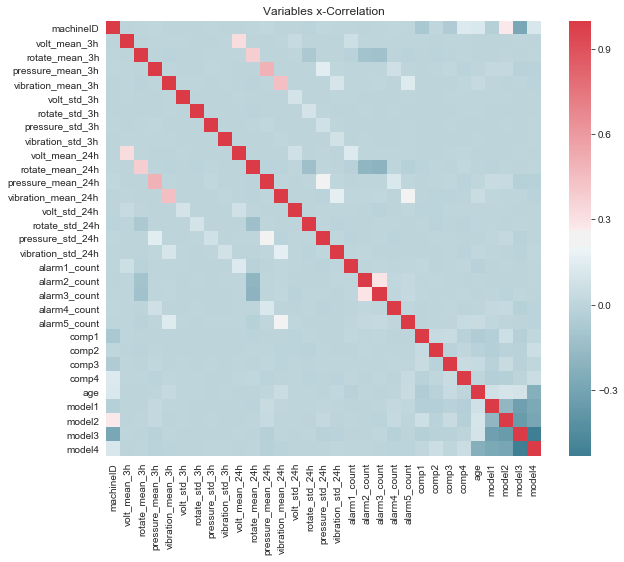

In [113]:
# It is necessary to eliminate the variables with high correlation (only one), consider> 70%.
f, ax = plt.subplots(figsize=(10, 8))
corr = labeled_features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title("Variables x-Correlation")
plt.show()

It clearly appears that almost all variable are not correlated !

In [100]:
# We save to apply hyper-parameter optimization.
labeled_features.to_pickle ("final_datset.pickle")

## Training and Test datasets preparation ####

When working with time series as in this example, the record partition in training, validation and testing should be done carefully to avoid overfitting of the models. In predictive maintenance, features are usually generated using delayed aggregates: records in the same time window will likely have identical labels and values of similar features. These correlations can give a model an "unfair advantage" by predicting a record belonging to the test set that shares its time window with a record of the training set. Therefore, we divide the records into training, validation and test sets in large portions, to minimize the number of time intervals overlapping.

Predictive models do not have an advanced knowledge of future chronological trends: in practice, these trends are likely to exist and have an adverse impact on the performance of the model. To obtain an accurate evaluation of the performance of a predictive model, it is recommended to perform training on older records and validation / testing using the newest records.

For both reasons, a time-dependent division of records strategy is an excellent option for predictive maintenance models. The division is made by choosing a point in time according to the desired size of the training and test sets: all the records before the point of time are used to train the model, and all the remaining records are used for the test.

In [101]:
# We define the date/time points corresponding to the records that will be used for training and tests.
threshold_dates = [
    pd.to_datetime("2015-09-30 01:00:00"), pd.to_datetime("2015-10-01 01:00:00")
]

In [102]:
test_results = []
models = []
total = len(threshold_dates)

# We partition the data set according to these dates.
last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [103]:
# Typically between 20 and 30% of the data is used.
ntraining = labeled_features.loc[labeled_features["datetime"] < last_train_date]
ntesting = labeled_features.loc[labeled_features["datetime"] > first_test_date]
print(f"{ntraining.shape[0]} Training set length.")
print(f"{ntesting.shape[0]} Testing set length.")
print(f"{ntesting.shape[0] / ntraining.shape[0] * 100:0.1f}% split ratio.")

240023 Training set length.
81189 Testing set length.
33.8% split ratio.


### Check labels imbalance

 There is an expected 'heavy' imbalance.

In [104]:
fails_train = ntraining[ntraining["failure"] != "none"].shape[0]
no_fails_train = ntraining[ntraining["failure"] == "none"].shape[0]
fails_test = ntesting[ntesting["failure"] != "none"].shape[0]
no_fails_test = ntesting[ntesting["failure"] == "none"].shape[0]

print(f"{fails_train / no_fails_train * 100:0.1f} % failure cases in the training set.")
print(f"{fails_test / no_fails_test * 100:0.1f} % failure cases in the testing set.")

1.8 % failure cases in the training set.
1.7 % failure cases in the testing set.


In [105]:
ntraining["failure"].unique()

[none, comp4, comp1, comp2, comp3]
Categories (5, object): [none, comp4, comp1, comp2, comp3]

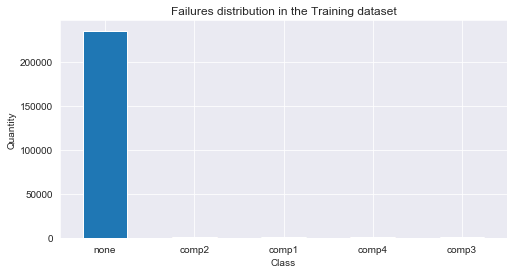

In [106]:
plt.figure(figsize=(8, 4))
ntraining["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Failures distribution in the Training dataset")
plt.xlabel("Class")
plt.ylabel("Quantity")
plt.show()

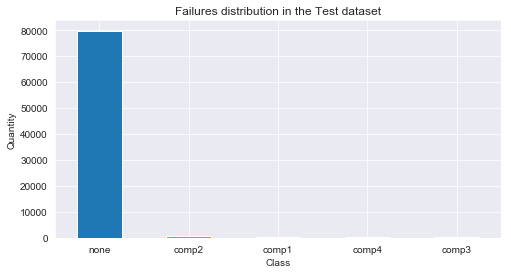

In [107]:
plt.figure(figsize=(8, 4))
ntesting["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Failures distribution in the Test dataset")
plt.xlabel("Class")
plt.ylabel("Quantity")
plt.show()

NOTE: For classes imbalance situation we shall either
    - Get more data.
    - Sub-sample majority class.
    - SMOTE (Synthetic Minority Over-sampling Technique).
    - Assign a weight to the minority class.

In [108]:
# Assign the values corresponding to training and tests.
train_y = labeled_features.loc[labeled_features["datetime"] < last_train_date, "failure"]
train_X = labeled_features.loc[labeled_features["datetime"] < last_train_date].drop(["datetime",
                                                                                    "machineID",
                                                                                    "failure"], axis=1)
test_y = labeled_features.loc[labeled_features["datetime"] > first_test_date, "failure"]
test_X = labeled_features.loc[labeled_features["datetime"] > first_test_date].drop(["datetime",
                                                                                   "machineID",
                                                                                   "failure"], axis=1)

### Transform target into multiclass labels 

In [109]:
lb = LabelBinarizer()

In [110]:
train_y.unique()

[none, comp4, comp1, comp2, comp3]
Categories (5, object): [none, comp4, comp1, comp2, comp3]

In [111]:
train_y.value_counts()

none     235718
comp2      1447
comp1      1152
comp4       962
comp3       744
Name: failure, dtype: int64

In [112]:
target_labels = ["comp1", 'comp2','comp3', 'comp4', 'no_failure']
labels_train = pd.DataFrame(lb.fit_transform(train_y), columns=target_labels)
labels_test = pd.DataFrame(lb.transform(test_y), columns = target_labels)

In [113]:
labels_train.shape, labels_test.shape

((240023, 5), (81189, 5))

In [114]:
labels_train.head()

,comp1,comp2,comp3,comp4,no_failure
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [115]:
labels_test.head()

,comp1,comp2,comp3,comp4,no_failure
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


## Features importance

In [116]:
# Model training.
model = xgb()
model.fit(train_X, train_y);

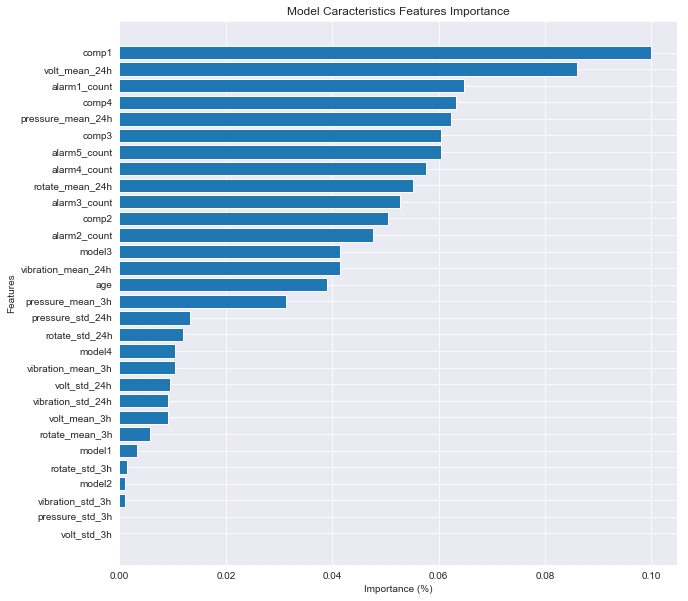

In [121]:
plt.figure(figsize=(10, 10))
labels, importances = zip(*sorted(zip(train_X.columns, model.feature_importances_), reverse=False, key=lambda x: x[1]))
plt.yticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.barh(range(len(importances)), importances)
plt.ylabel("Features")
plt.xlabel("Importance (%)")
plt.title("Model Caracteristics Features Importance")
plt.show()

In [122]:
df_temp = pd.DataFrame(model.feature_importances_, columns = ["importance"], index = test_X.columns)
df_temp.sort_values(by=["importance"], ascending=False, inplace = True)
df_temp

,importance
comp1,0.099905
volt_mean_24h,0.086108
alarm1_count,0.064700
comp4,0.063273
pressure_mean_24h,0.062322
comp3,0.060419
alarm5_count,0.060419
alarm4_count,0.057564
rotate_mean_24h,0.055186
alarm3_count,0.052807


It appears that features 'pressure_std_3H' and 'volt_std_3H' do not bring any information to the modeling problem.

In [123]:
select_feat_xgb = list(df_temp[df_temp["importance"] > 0.0 ].index)
select_feat_xgb

['comp1',
 'volt_mean_24h',
 'alarm1_count',
 'comp4',
 'pressure_mean_24h',
 'comp3',
 'alarm5_count',
 'alarm4_count',
 'rotate_mean_24h',
 'alarm3_count',
 'comp2',
 'alarm2_count',
 'model3',
 'vibration_mean_24h',
 'age',
 'pressure_mean_3h',
 'pressure_std_24h',
 'rotate_std_24h',
 'vibration_mean_3h',
 'model4',
 'volt_std_24h',
 'volt_mean_3h',
 'vibration_std_24h',
 'rotate_mean_3h',
 'model1',
 'rotate_std_3h',
 'vibration_std_3h',
 'model2']

NOTE: For variable selection
    * Pearson Correlation: Linear dependence between two continuous variables.
    * LDA: Find the best linear combination of variables capable of separating categorical classes.
    * ANOVA: Combination of categorical variables to estimate continuous variable.
    * Chi-Square: Search for correlations between groups of categorical variables.
    * Forward selection: Add variables one by one and observe performance.
    * Elimination backwards: Eliminate variables one by one and observe performance.
    * Recursive elimination: Optimization algorithm for tests with different subsets of variables.
    * We revolve the columns one by one and evaluate results.

## Modeling #

### Features scaling

As we have spare data within our features dataset, we would rather prefer to scale variables using a MinMax scaler [0,1].

Let's pick first, selected features only !

In [124]:
#select_cols = test_X.columns # if we consider full variables set
select_cols = select_feat_xgb # variables selected from their importance
sc=MinMaxScaler() # because we have category dummies (0,1)

train_X[select_cols]=sc.fit_transform(train_X[select_cols])                       # no class balancing
#train_X_upsampled[select_cols]=sc.fit_transform(train_X_upsampled[select_cols])  # with class balancing
test_X[select_cols]=sc.transform(test_X[select_cols])

In [125]:
train_X.describe()

,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_std_3h,rotate_std_3h,pressure_std_3h,vibration_std_3h,volt_mean_24h,rotate_mean_24h,...,alarm5_count,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
count,240023.000000,240023.000000,240023.000000,240023.000000,240023.000000,240023.000000,240023.000000,240023.000000,240023.000000,240023.000000,...,240023.000000,240023.000000,240023.000000,240023.000000,240023.000000,240023.000000,240023.000000,240023.000000,240023.000000,240023.00000
mean,0.390455,0.629553,0.318021,0.323530,13.286998,0.246642,8.877551,0.242017,0.230444,0.788871,...,0.004877,0.126215,0.156196,0.152593,0.150359,0.559615,0.144494,0.160255,0.388250,0.30700
std,0.081829,0.088656,0.081452,0.081501,6.970045,0.129078,4.644906,0.126988,0.072615,0.078834,...,0.049455,0.150719,0.188632,0.170993,0.167363,0.290235,0.351591,0.366844,0.487353,0.46125
min,0.000000,0.000000,0.000000,0.000000,0.025509,0.000000,0.027417,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.335936,0.578506,0.267245,0.271117,8.002413,0.149146,5.369781,0.145912,0.188784,0.766568,...,0.000000,0.028524,0.033680,0.036063,0.035202,0.350000,0.000000,0.000000,0.000000,0.00000
50%,0.387467,0.634319,0.311401,0.317842,12.475928,0.231798,8.342288,0.227446,0.221765,0.800165,...,0.000000,0.071860,0.083124,0.090664,0.087833,0.550000,0.000000,0.000000,0.000000,0.00000
75%,0.440717,0.687849,0.357497,0.366579,17.676722,0.328240,11.770006,0.322103,0.256422,0.831564,...,0.000000,0.157570,0.192404,0.193461,0.197198,0.800000,0.000000,0.000000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,58.444332,1.000000,34.910352,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


### Multi-labels models construction 

For the sake of this DS workflow, we will only use 2 classifiers: a baseline classifier (Logistic regression) and an ensemble classifier (RandomForest).

In [126]:
# Grid parameters for Logistic regression classifier
param_grid1 = [{
             'C'     : [0.1, 1.0, 2.0, 10.0] ,
             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
             }]

# Grid parameters for RandomForestClassifier classifier
param_grid2 = [{
             'n_estimators' : [5, 10, 30, 50, 100], 
             'max_depth'    : [1, 2, 5, 10]
             }]

param_grid = {'logit' : param_grid1,
              'RanForest': param_grid2
             }


In [127]:
param_grid['RanForest']

[{'n_estimators': [5, 10, 30, 50, 100], 'max_depth': [1, 2, 5, 10]}]

In [128]:
models = {'clf1': LogisticRegression(penalty='l2', 
                                         C=1.0, 
                                         fit_intercept=True, 
                                         class_weight="balanced",  # to deal with imbalanced classes
                                         random_state=None, 
                                         solver='lbfgs', 
                                         multi_class='multinomial',
                                         max_iter=100, 
                                         verbose=0, 
                                         warm_start=False, 
                                         n_jobs=-1),
              
          'clf2': RandomForestClassifier(n_estimators='warn', 
                                             criterion='gini', 
                                             max_depth=None, 
                                             min_samples_split=2, 
                                             min_samples_leaf=1, 
                                             max_features='auto',  
                                             class_weight= "balanced", # to deal with imbalanced classes
                                             random_state=None, 
                                             verbose=0, 
                                             warm_start=False, 
                                             n_jobs=-1)
             }

In [132]:
%%time
search = []

for i, (clf,param) in enumerate(zip(models, param_grid)):
    print("Gridsearch step for classifier %d" % (i+1))
    
    clf_temp = GridSearchCV(models[clf], param_grid[param], iid=False, cv=5, scoring='accuracy')  #scoring='accuracy', roc_auc', 'f1'
    
    clf_temp.fit(train_X[select_cols], train_y)                      # imbalanced classes
    
    search.append(clf_temp)
    print("Best parameter for classifier {} (CV score={}):".format(clf,search[i].best_score_))
    print(search[i].best_params_)

    #clf.set_params(**search.best_params_)
    models[clf] = search[i].best_estimator_

    print()
    print(models[clf].get_params)
    print()
    

Gridsearch step for classifier 1
Best parameter for classifier clf1 (CV score=0.9934589864670947):
{'C': 10.0, 'solver': 'lbfgs'}

<bound method BaseEstimator.get_params of LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)>

Gridsearch step for classifier 2
Best parameter for classifier clf2 (CV score=0.997879430172466):
{'max_depth': 10, 'n_estimators': 50}

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=

In [133]:
models['clf1'].classes_

array(['comp1', 'comp2', 'comp3', 'comp4', 'none'], dtype=object)

In [136]:
len(models['clf1'].coef_[0] )

28

In [137]:
labels_train.columns

Index(['comp1', 'comp2', 'comp3', 'comp4', 'no_failure'], dtype='object')

In [138]:
labels_train.head()

,comp1,comp2,comp3,comp4,no_failure
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


#### Training metrics

Models trained on 'imbalanced' training dataset.

In [139]:
for i,clf in enumerate(models):
    res = models[clf].score(train_X[select_cols], train_y) 
    error = np.mean(search[i].cv_results_['std_train_score'])
    print("Training score (accuracy) for classifier {}: {:0.4f} +/- {:0.6f}".format(clf,res, error)) # balanced classes

Training score (accuracy) for classifier clf1: 0.9942 +/- 0.016893
Training score (accuracy) for classifier clf2: 0.9982 +/- 0.017169


## Evaluation ##

#### Test metrics

In [140]:
# Test metrics
predict = {}
yhat = {}
for i,clf in enumerate(models):
    yhat['y_pred']       = models[clf].predict(test_X[select_cols])
    yhat['y_pred_proba'] = models[clf].predict_proba(test_X[select_cols])
    predict[clf] = yhat 
    error = np.mean(search[i].cv_results_['std_test_score'])
    print('Accuracy of classifier {} on test data: {:0.4f} +/- {:0.6f}'.format(clf, 
                                                                     accuracy_score(test_y,yhat['y_pred']),
                                                                     error) )

Accuracy of classifier clf1 on test data: 0.9941 +/- 0.021066
Accuracy of classifier clf2 on test data: 0.9982 +/- 0.018037


In [143]:
# Test metrics

target_names = list(labels_train.columns)

for i,clf in enumerate(models):
    print('Evaluation scores of classifier {} on test data'.format(clf))
    print(classification_report(test_y,predict[clf]['y_pred'], target_names=target_names))
    print()

Evaluation scores of classifier clf1 on test data
              precision    recall  f1-score   support

       comp1       0.89      0.93      0.91       323
       comp2       0.89      1.00      0.94       565
       comp3       1.00      0.94      0.97       224
       comp4       0.96      0.98      0.97       282
  no_failure       1.00      1.00      1.00     79795

   micro avg       1.00      1.00      1.00     81189
   macro avg       0.95      0.97      0.96     81189
weighted avg       1.00      1.00      1.00     81189


Evaluation scores of classifier clf2 on test data
              precision    recall  f1-score   support

       comp1       0.89      0.93      0.91       323
       comp2       0.89      1.00      0.94       565
       comp3       1.00      0.94      0.97       224
       comp4       0.96      0.98      0.97       282
  no_failure       1.00      1.00      1.00     79795

   micro avg       1.00      1.00      1.00     81189
   macro avg       0.95      0

In [144]:
pd.DataFrame(data = predict['clf2']['y_pred'][:5], columns=["failure"], dtype="category")

,failure
0,none
1,none
2,none
3,none
4,none


In [145]:
pd.DataFrame(data = predict['clf2']['y_pred_proba'][:5], 
             columns = ["comp1", "comp2", "comp3", "comp4","none"], dtype = "float64")

,comp1,comp2,comp3,comp4,none
0,0.000377,0.000000,0.000047,0.000000,0.999576
1,0.000377,0.000000,0.000047,0.000000,0.999576
2,0.000377,0.000077,0.000047,0.001394,0.998105
3,0.000377,0.000077,0.000047,0.001394,0.998105
4,0.017280,0.000077,0.000000,0.001394,0.981249


In [146]:
test_y.dtype
truth = test_y.copy().reset_index().drop("index",axis=1)
#truth.columns = ['Failure']
print(truth.info())
truth.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81189 entries, 0 to 81188
Data columns (total 1 columns):
failure    81189 non-null category
dtypes: category(1)
memory usage: 79.6 KB
None


,failure
0,none
1,none
2,none
3,none
4,none


CONFUSIN MATRIX FOR CLASSIFIER clf1


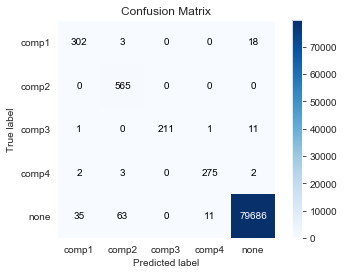

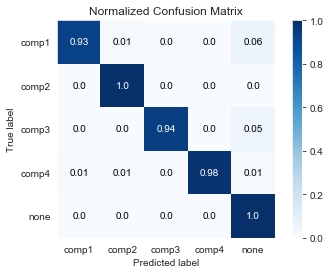

                                       comp1     comp2     comp3     comp4  \
accuracy                            0.992663  0.992663  0.992663  0.992663   
precision                           0.888235  0.891167  1.000000  0.958188   
recall                              0.934985  1.000000  0.941964  0.975177   
F1                                  0.911011  0.942452  0.970115  0.966608   
macro precision                     0.747518  0.747518  0.747518  0.747518   
macro recall                        0.770425  0.770425  0.770425  0.770425   
macro F1                                 NaN       NaN       NaN       NaN   
average accuracy                    0.997065  0.997065  0.997065  0.997065   
micro-averaged precision/recall/F1  0.992663  0.992663  0.992663  0.992663   
majority class accuracy             0.000000  0.414527  0.000000  0.000000   
majority class recall               0.000000  1.000000  0.000000  0.000000   
majority class precision            0.000000  0.414527  0.000000

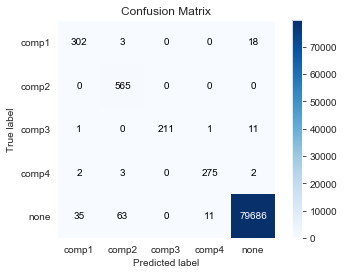

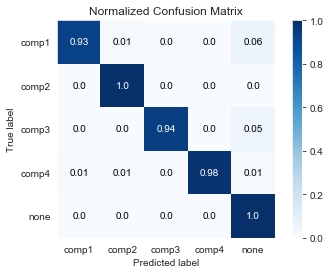

                                       comp1     comp2     comp3     comp4  \
accuracy                            0.992663  0.992663  0.992663  0.992663   
precision                           0.888235  0.891167  1.000000  0.958188   
recall                              0.934985  1.000000  0.941964  0.975177   
F1                                  0.911011  0.942452  0.970115  0.966608   
macro precision                     0.747518  0.747518  0.747518  0.747518   
macro recall                        0.770425  0.770425  0.770425  0.770425   
macro F1                                 NaN       NaN       NaN       NaN   
average accuracy                    0.997065  0.997065  0.997065  0.997065   
micro-averaged precision/recall/F1  0.992663  0.992663  0.992663  0.992663   
majority class accuracy             0.000000  0.414527  0.000000  0.000000   
majority class recall               0.000000  1.000000  0.000000  0.000000   
majority class precision            0.000000  0.414527  0.000000

In [147]:
evaluation_results = []

# Transform target and prediction into dataframes
#truth = pd.DataFrame(data = test_y.values, columns=["Failure"], dtype="category")
truth = test_y.copy().reset_index().drop("index",axis=1)

for clf in models:
    pred  = pd.DataFrame(data = predict[clf]['y_pred'], columns=["failure"], dtype="category")

    results = Evaluate(actual = truth,
                       predicted = pred,
                       labels = ["comp1", "comp2", "comp3", "comp4","no-failure"])
    evaluation_results.append(results)
    # Plot confusion matrix
    #fig, ax = plt.subplots(1,2)
    #font = {'weight' : 'normal',
    #        'size'   : 8}
    #plt.rc('font', **font)
    #plt.figure(figsize=(8, 5))

    #plt.subplot(1,2,1)
    print("CONFUSIN MATRIX FOR CLASSIFIER {}".format(clf))
    skplt.metrics.plot_confusion_matrix(truth, pred, normalize=False, title="Confusion Matrix")
    #plt.subplot(1,2,2)
    skplt.metrics.plot_confusion_matrix(truth, pred, normalize=True, title="Normalized Confusion Matrix")
    plt.show()

    print(results )  # show full results for first split only
    print("\n\n")

NOTE
    - precision: TP / (TP + FP), we find more.
    - recall: TP / (TP + FN), we find less. If we say that all fail: 1
    - F1: 2 * (precision * recall) / (precision + recall)

We are interested in how many errors were found (recall).

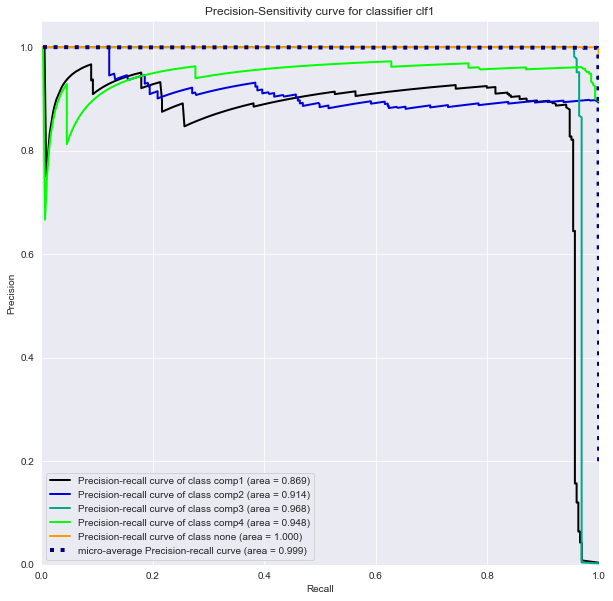

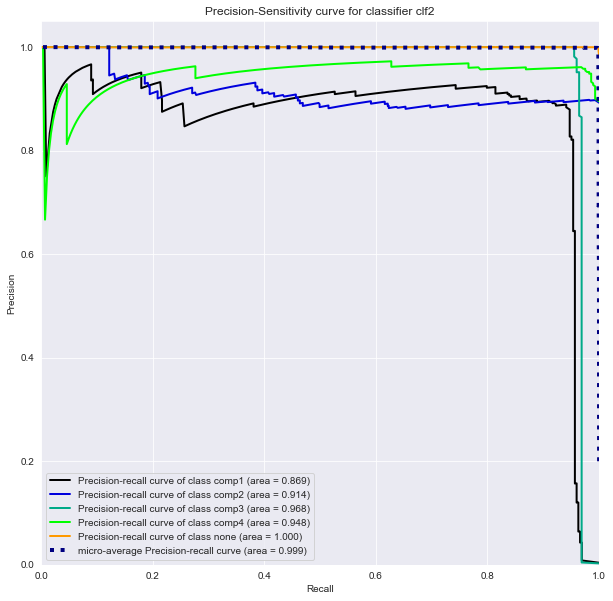

In [148]:
# For a Binary classification we generally use ROC-AUC curve.
# For this multi-class classification problem we use precision vs. sensitivity curve.
for clf in models:
    skplt.metrics.plot_precision_recall_curve(test_y,
                                              predict[clf]['y_pred_proba'],
                                              title="Precision-Sensitivity curve for classifier {}".format(clf),
                                              figsize=(10,10)
                                             )
    plt.show()

In [149]:
evaluation_results[0].loc["recall"].values

array([0.93498452, 1.        , 0.94196429, 0.9751773 , 0.        ])

In [150]:
recall = []
for i in range(len(evaluation_results)):
    recall_df = pd.DataFrame([evaluation_results[i].loc["recall"].values],
                             columns=["comp1", "comp2", "comp3", "comp4", "none"],
                             index=["Component sensitivity"])
    recall.append(recall_df.T)
    print("Classifier {}\n".format(i+1))
    print(recall[i] )
    print()

Classifier 1

       Component sensitivity
comp1               0.934985
comp2               1.000000
comp3               0.941964
comp4               0.975177
none                0.000000

Classifier 2

       Component sensitivity
comp1               0.934985
comp2               1.000000
comp3               0.941964
comp4               0.975177
none                0.000000



### ROC Curves

ROC CURVE FOR CLASSIFIER clf1


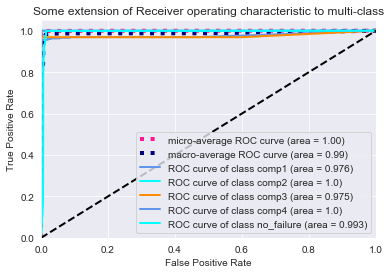




ROC CURVE FOR CLASSIFIER clf2


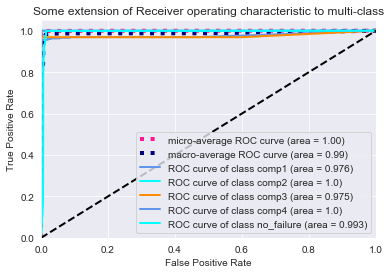

In [151]:
# Make sure to pass 'Binarized' Target values of the Test dataset !!

for clf in models:
    print("ROC CURVE FOR CLASSIFIER {}".format(clf))
    plot_multi_roc_curve(labels_test.values, predict[clf]['y_pred_proba'], list(labels_test.columns) )
    print("\n\n")

## Individual test case ####

Let's pick a record at random from the Test dataset.

In [170]:
labeled_features.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_std_3h,rotate_std_3h,pressure_std_3h,vibration_std_3h,...,comp1,comp2,comp3,comp4,age,failure,model1,model2,model3,model4
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,20.000,215.000,155.000,170.000,18,none,0,0,1,0
1,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,20.000,215.000,155.000,170.000,18,none,0,0,1,0
2,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,20.125,215.125,155.125,170.125,18,none,0,0,1,0
3,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,20.125,215.125,155.125,170.125,18,none,0,0,1,0
4,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,20.250,215.250,155.250,170.250,18,none,0,0,1,0


In [177]:
idx = np.random.random_integers(0,test_X.shape[0],1)
test_idx_offset = test_X.index.tolist()[0]
machine_id = int(labeled_features.loc[test_idx_offset + idx, 'machineID'].values)
time_ref = pd.to_datetime(labeled_features.loc[test_idx_offset + idx, 'datetime'].values)
test_values = test_X.iloc[idx].values
single_test = pd.DataFrame(test_values, columns=test_X.columns, index=[0])
print("Machine ID selected: ", machine_id)
print("Time reference selected: ", time_ref)
single_test

Machine ID selected:  7
Time reference selected:  DatetimeIndex(['2015-09-16 21:00:00'], dtype='datetime64[ns]', freq=None)


,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_std_3h,rotate_std_3h,pressure_std_3h,vibration_std_3h,volt_mean_24h,rotate_mean_24h,...,alarm5_count,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,0.325806,0.608612,0.266442,0.251561,16.32905,0.152516,11.228279,0.266033,0.214028,0.876106,...,0.0,0.4435,0.192404,0.059656,0.019481,0.75,0.0,0.0,0.0,1.0


In [178]:
# Make sure we pick only selected features from scaled test dataset.
ordered_classes = np.unique(np.array(test_y))
for clf in models:
    probas = models[clf].predict_proba(single_test[select_cols])
    prediction = models[clf].predict(single_test[select_cols])
    results = pd.DataFrame(probas,
                           columns=ordered_classes,
                           index=[0])
    print("Machine ID {} / Time reference: {}".format(machine_id, time_ref)) 
    print("Next 24H Failure Prediction for classifier {}: {}\n".format(clf, prediction[0]))
    print(results)
    print()

Machine ID 7 / Time reference: DatetimeIndex(['2015-09-16 21:00:00'], dtype='datetime64[ns]', freq=None)
Next 24H Failure Prediction for classifier clf1: none

          comp1         comp2         comp3         comp4  none
0  1.038966e-10  8.221163e-13  1.983827e-20  1.475630e-12   1.0

Machine ID 7 / Time reference: DatetimeIndex(['2015-09-16 21:00:00'], dtype='datetime64[ns]', freq=None)
Next 24H Failure Prediction for classifier clf2: none

     comp1  comp2     comp3  comp4      none
0  0.00445    0.0  0.000047    0.0  0.995503



## Useful Links ##

NASA sensors case: Predictive Maintenance ML (IIoT):
https://www.kaggle.com/billstuart/predictive-maintenance-ml-iiot


From SQL to Pandas:
https://medium.com/jbennetcodes/how-to-rewrite-your-sql-queries-in-pandas-and-more-149d341fc53e?mkt_tok=eyJpIjoiWldSa01EZGtPRFE0TTJRNCIsInQiOiJoV0V6RFZ6UFVHTnc5NGVzaHNzSTZaS1pxc1Z3WVJsYWE5NmRocmNBOW9UdkJTSDV5d1cyRVJ4czBVYnJPZnZZekJiXC9QWE1xSFBDdjVOOEtlT2FoZ0xVUElxWWMzMk0xamt2Y09nN1pIdCtSQnVic3F1YmluZHQ5WGlpYlpcL09CIn0%3D
